# Importing required packages

In [4]:
import os, tensorflow as tf, keras, numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import he_normal

# Loading Datasets

In [6]:
from PIL import Image
import pandas as pd
import glob

train_dir = os.path.join("/kaggle/input/openaimer-2025-track1-dataset/OpenAImer2025_Image_Classification/OpenAImer/train")
test_dir = os.path.join("/kaggle/input/openaimer-2025-track1-dataset/OpenAImer2025_Image_Classification/OpenAImer/test")

test_image_paths = glob.glob(test_dir + "/*.jpg")

test_df = pd.DataFrame({
    'filename': test_image_paths,
    'class': ['unknown'] * len(test_image_paths)
})

# img = Image.open("/kaggle/input/openaimer-2025-track1-dataset/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao100429.jpg")
# width, height = img.size
# print(f"Image resolution: {width}x{height}")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
input_shape = (224, 224, 3)
projection_units = 128
num_classes = 7
batch_size = 32
encoder_trainable = True
dropout_rate1 = 0.4
dropout_rate2 = 0.1

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset = 'training'     
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
)

Found 3043 images belonging to 7 classes.
Found 1401 validated image filenames belonging to 1 classes.


# Encoder with Projection Head

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 1: Create the base encoder model using DenseNet201 architecture
def create_encoder(trainable=True):
    base_model = keras.applications.DenseNet201(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
        pooling="avg"
    )
    base_model.trainable = trainable
    
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs)
    outputs = layers.Dense(512, activation=None)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="encoder")
    
    return model


# Step 2: Add projection head for contrastive learning
def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection_head"
    )
    
    return model

# Classifier

In [8]:
def create_classifier(encoder, trainable=False):
    for layer in encoder.layers:
        layer.trainable = False
    
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = Dropout(dropout_rate1)(features)
    features = Dense(32, activation='relu')(features)
    features = Dropout(dropout_rate2)(features)
    outputs = Dense(num_classes, activation="softmax")(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="classifier")
    
    return model

# Supervised Contrastive Loss (SupCon)

In [9]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.07, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def call(self, labels, feature_vectors):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        
        logits = tf.divide(
            tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)),
            self.temperature
        )

        logits_mask = tf.linalg.diag(tf.zeros(tf.shape(logits)[0])) + tf.ones_like(logits) - tf.eye(tf.shape(logits)[0])

        labels = tf.reshape(labels, [-1, 1])
        matches = tf.equal(labels, tf.transpose(labels))
        matches = tf.cast(matches, tf.float32)
        
        matches *= logits_mask

        exp_logits = tf.exp(logits) * logits_mask
        log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-9)

        mean_log_prob_pos = tf.reduce_sum(matches * log_prob, axis=1) / (tf.reduce_sum(matches, axis=1) + 1e-9)
        
        loss = -tf.reduce_mean(mean_log_prob_pos)
        
        return loss

In [10]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00


# T-SNE Plot

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


def visualize_latent_space(encoder, dataset, class_indices, method="tsne", title="Latent Space Visualization"):
    features = []
    labels = []
    dataset.reset()
    
    max_samples = 500
    sample_count = 0
    
    for images, batch_labels in dataset:
        batch_features = encoder.predict(images, verbose=0)
        
        if len(batch_features.shape) > 2:
            batch_features = batch_features.reshape(batch_features.shape[0], -1)
        
        features.append(batch_features)
        
        if len(batch_labels.shape) > 1 and batch_labels.shape[1] > 1:
            batch_labels = np.argmax(batch_labels, axis=1)
        
        labels.append(batch_labels)
        
        sample_count += len(images)
        if sample_count >= max_samples:
            break

    features = np.vstack(features)
    labels = np.concatenate(labels)
    
    print(f"Reducing dimensionality with {method.upper()}...")
    
    pca = PCA(n_components=min(50, features.shape[1]))
    features_pca = pca.fit_transform(features)
    
    if method.lower() == "tsne":
        
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    elif method.lower() == "umap":
        try:
            reducer = umap.UMAP(n_components=2, random_state=42)
        except ImportError:
            print("UMAP not installed. Falling back to t-SNE.")
            reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    else:
        print(f"Unknown method: {method}. Falling back to t-SNE.")
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    
    features_2d = reducer.fit_transform(features_pca)
    
    plt.figure(figsize=(12, 10))
    
    unique_labels = np.unique(labels)
    
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(
            features_2d[mask, 0], 
            features_2d[mask, 1], 
            c=[cmap(i)], 
            label=class_indices.get(label, f"Class {label}"),
            alpha=0.7,
            s=50
        )
    
    plt.title(f"{title} ({method.upper()})", fontsize=16)
    plt.xlabel(f'{method.upper()} Component 1', fontsize=12)
    plt.ylabel(f'{method.upper()} Component 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()

# Latent Space (Pre Contrastive Learning)

I0000 00:00:1744960856.093866      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1744960870.684331     105 service.cc:148] XLA service 0x7d809c011e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744960870.685088     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744960872.800667     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744960889.648919     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Reducing dimensionality with TSNE...


/tmp/ipykernel_31/450180300.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


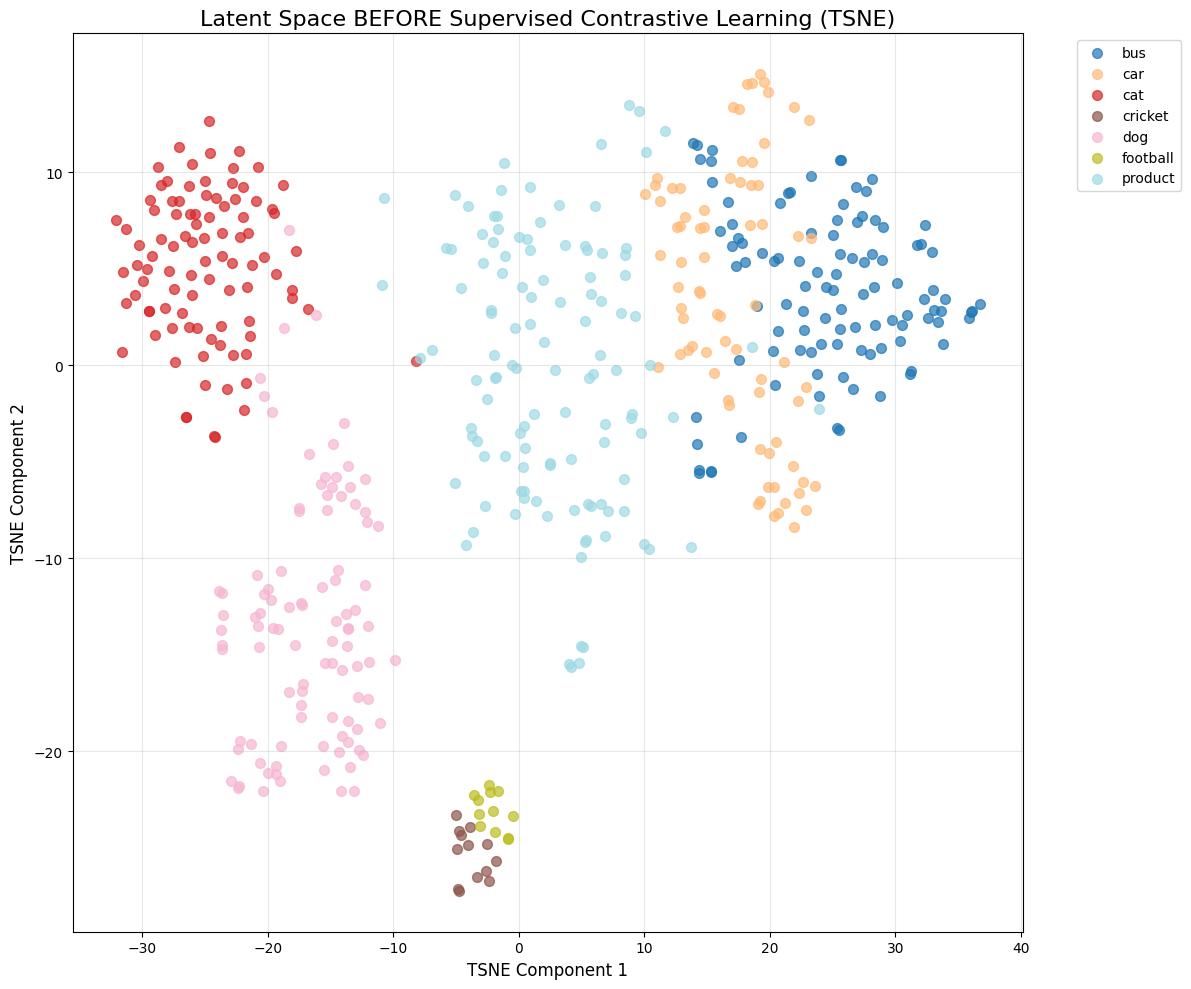

In [12]:
base_encoder = create_encoder(trainable=True)

# Visualize latent space before training
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}
visualize_latent_space(
    base_encoder, 
    train_generator, 
    class_indices_inverse, 
    method="tsne",
    title="Latent Space BEFORE Supervised Contrastive Learning"
)

# Pretraining Encoder with SupCon Loss

In [13]:
def train_encoder(train_generator, epochs=10):
    # Create the encoder and projection head
    encoder = create_encoder(trainable=True)
    encoder_with_projection = add_projection_head(encoder)

    supcon_loss = SupervisedContrastiveLoss(temperature=0.1)
    
    encoder_with_projection.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=supcon_loss,
    )

    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-8)
    
    # checkpoints
    checkpoint = [
        ModelCheckpoint(
            "/kaggle/working/encoder_with_projection.weights.h5",
            monitor="loss", 
            save_best_only=True, 
            save_weights_only=True, 
            mode="min",
            verbose=1
        )
    ]
    
    history = encoder_with_projection.fit(
        train_generator,
        epochs=epochs,
        callbacks=[lr_scheduler, checkpoint]
    )
    
    encoder_with_projection.load_weights("/kaggle/working/encoder_with_projection.weights.h5")
    
    trained_encoder = encoder
    
    return trained_encoder, history

# Training Classifier

In [14]:
def train_classifier(encoder, train_generator, val_generator=None, epochs=10):
    # Create the classifier with the frozen encoder
    classifier = create_classifier(encoder, trainable=False)
    
    classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='SparseCategoricalCrossentropy',
        metrics=["accuracy"]
    )

    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-8)
    
    checkpoint = [
        ModelCheckpoint(
            "/kaggle/working/track1_classifier.weights.h5", 
            monitor="loss", 
            save_best_only=True, 
            save_weights_only=True, 
            mode="min", 
            verbose=1
        )
    ]
    
    history = classifier.fit(
        train_generator,
        epochs=epochs,
        callbacks=[lr_scheduler, checkpoint]
    )

    classifier.load_weights("/kaggle/working/track1_classifier.weights.h5")
    
    return classifier, history

# Fitting the Encoder

In [15]:
print("Class mapping:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
    
# Train the encoder with contrastive learning
print("\n=== Training Encoder with Contrastive Learning ===")
trained_encoder, encoder_history = train_encoder(
    train_generator=train_generator,
    epochs=35
)

Class mapping: {'bus': 0, 'car': 1, 'cat': 2, 'cricket': 3, 'dog': 4, 'football': 5, 'product': 6}
Number of classes: 7

=== Training Encoder with Contrastive Learning ===
Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/96 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - loss: 2.2721

2025-04-18 07:31:53.885043: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_148630__.89419] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-04-18 07:32:40.869144: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m46.984283985s

********************************
[Compiling module a_inference_one_step_on_data_148630__.89419] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2.0658
Epoch 1: loss improved from inf to 1.86185, saving model to /kaggle/working/encoder_with_projection.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 676s 3s/step - loss: 2.0637 - learning_rate: 1.0000e-04
Epoch 2/35
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 1.6865
Epoch 2: loss improved from 1.86185 to 1.66738, saving model to /kaggle/working/encoder_with_projection.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 1.6863 - learning_rate: 1.0000e-04
Epoch 3/35
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 1.6435
Epoch 3: loss improved from 1.66738 to 1.63924, saving model to /kaggle/working/encoder_with_projection.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - loss: 1.6434 - learning_rate: 1.0000e-04
Epoch 4/35
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 1.6531
Epoch 4: loss did not improve from 1.63924
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - loss: 1.6530 - learning_rate: 1.0000e-04
Epoch 5/35
96/96 ━━━━━━━

# Latent Space (Post Contrastive Learning)

Reducing dimensionality with TSNE...


/tmp/ipykernel_31/450180300.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


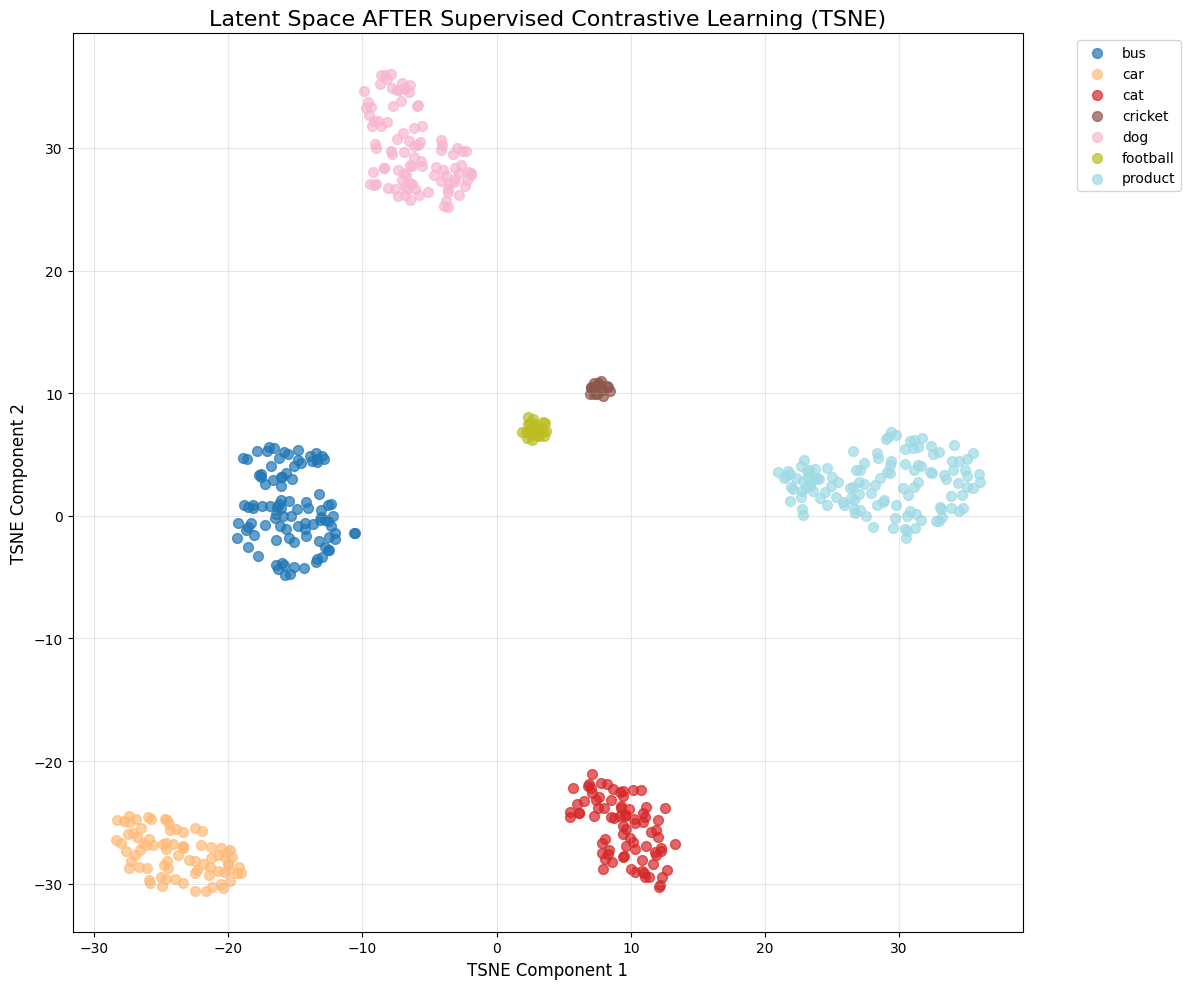

In [16]:
# After training, visualize the trained encoder
visualize_latent_space(
    trained_encoder, 
    train_generator, 
    class_indices_inverse, 
    method="tsne",
    title="Latent Space AFTER Supervised Contrastive Learning"
)

# Fitting the Classifier

In [17]:
# Train the classifier using the trained encoder
print("\n=== Training Classifier with Frozen Encoder ===")
classifier, classifier_history = train_classifier(
    encoder=trained_encoder,
    train_generator=train_generator,
    epochs=25
)


=== Training Classifier with Frozen Encoder ===
Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2238 - loss: 2.9289
Epoch 1: loss improved from inf to 2.02350, saving model to /kaggle/working/track1_classifier.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 70s 276ms/step - accuracy: 0.2257 - loss: 2.9196 - learning_rate: 1.0000e-04
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8694 - loss: 0.5317
Epoch 2: loss improved from 2.02350 to 0.42221, saving model to /kaggle/working/track1_classifier.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.8697 - loss: 0.5305 - learning_rate: 1.0000e-04
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9558 - loss: 0.2205
Epoch 3: loss improved from 0.42221 to 0.18103, saving model to /kaggle/working/track1_classifier.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9560 - loss: 0.2201 - learning_rate: 1.0000e-04
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0

# Plotting Accuracy and Loss

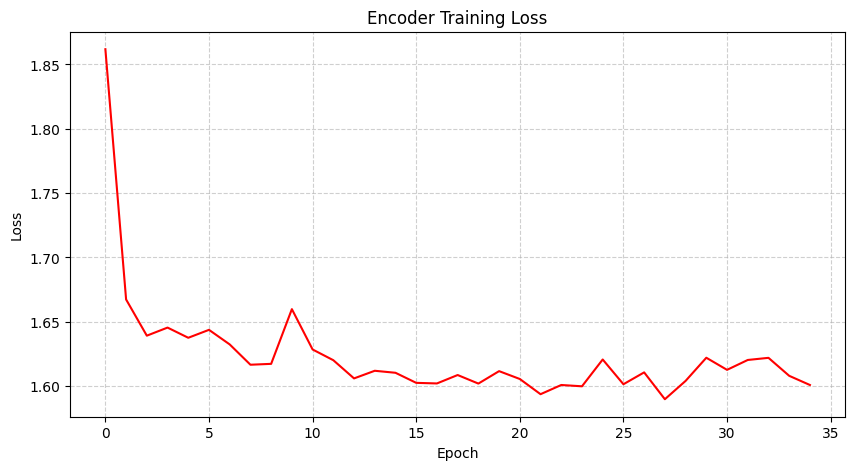

Final encoder training loss: 1.6009


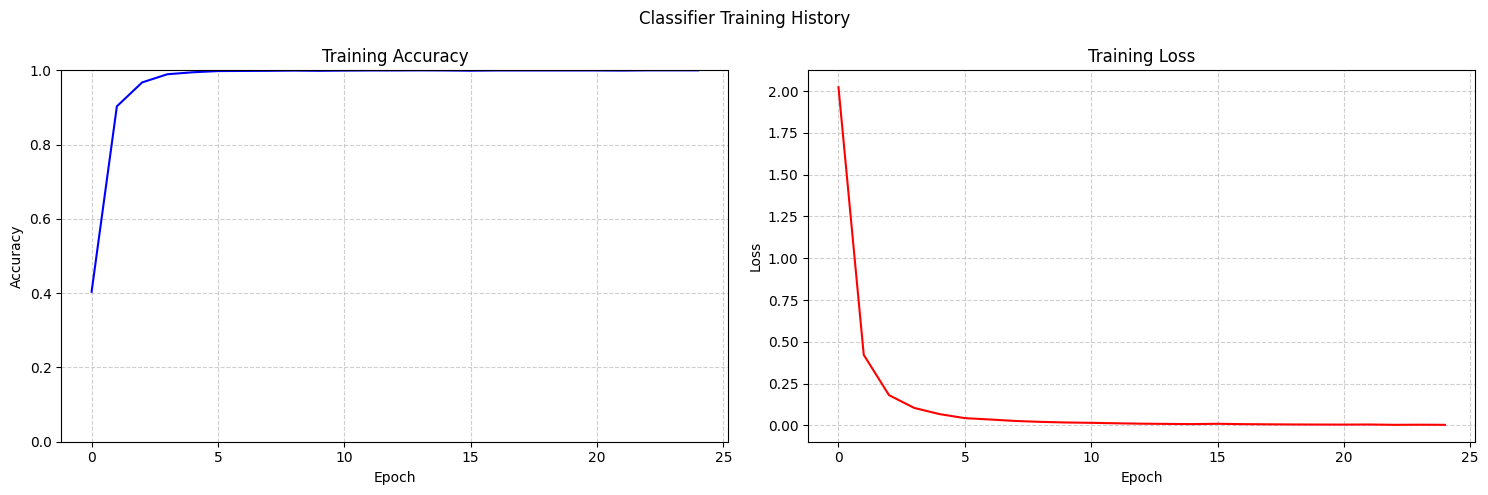

Final training accuracy: 1.0000
Final training loss: 0.0034


In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_type="classifier", title="Training History"):
    
    if model_type.lower() == "classifier":
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(history.history['accuracy'], 'b-')
        ax1.set_title('Training Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylim([0, 1.0])
        ax1.grid(True, linestyle='--', alpha=0.6)
        
        ax2.plot(history.history['loss'], 'r-')
        ax2.set_title('Training Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.grid(True, linestyle='--', alpha=0.6)
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
        
        print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"Final training loss: {history.history['loss'][-1]:.4f}")
        
    elif model_type.lower() == "encoder":
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], 'r-')
        plt.title('Encoder Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        
        print(f"Final encoder training loss: {history.history['loss'][-1]:.4f}")


plot_training_history(encoder_history, model_type="encoder", title="Encoder Training History")

plot_training_history(classifier_history, model_type="classifier", title="Classifier Training History")

# Predictions

In [19]:
import numpy as np
import re
import os
import pandas as pd
from collections import OrderedDict

preds = classifier.predict(test_generator, verbose=1)
pred_classes_encoded = np.argmax(preds, axis=1)

image_ids = [
    re.findall(r'\d+', os.path.basename(name))[0]
    for name in test_generator.filenames
]

class_mapping = dict(train_generator.class_indices)
pred_classes = [
    list(class_mapping.keys())[list(class_mapping.values()).index(i)]
    for i in pred_classes_encoded
]

predictions = {
    image_ids[i]: pred_classes[i]
    for i in range(len(pred_classes))
}

predictions = dict(OrderedDict(sorted(predictions.items(), key=lambda x: int(x[0]))))

print(predictions)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 759ms/step
{'60072': 'football', '60078': 'cat', '60102': 'football', '60103': 'cat', '60109': 'cat', '60174': 'football', '60217': 'cat', '60258': 'cat', '60282': 'cat', '60296': 'cat', '60308': 'cat', '60327': 'cat', '60329': 'cat', '60335': 'cat', '60361': 'cat', '60372': 'cat', '60399': 'cat', '60405': 'cat', '60406': 'cat', '60459': 'cat', '60478': 'football', '60529': 'cat', '60536': 'football', '60568': 'cat', '60586': 'cat', '60588': 'football', '60635': 'football', '60645': 'cat', '60680': 'football', '60696': 'cat', '60707': 'cat', '60792': 'cat', '60807': 'cat', '60822': 'cat', '60824': 'cat', '60849': 'football', '60853': 'cat', '60876': 'cat', '60908': 'football', '60958': 'cat', '60966': 'dog', '60976': 'cat', '61002': 'cat', '61004': 'cat', '61031': 'football', '61048': 'cat', '61147': 'cat', '61209': 'cat', '61220': 'cat', '61242': 'football', '61257': 'cat', '61258': 'cat', '61275': 'cat', '61319': 'cat', '61329': 'football', '61383': 'fo

# Saving predictions in CSV 

In [75]:
import csv

output_path = "/kaggle/working/track1.csv"

# Write the predictions to a CSV file
with open(output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_id", "label"]) 
    for image_id, label in predictions.items():
        writer.writerow([image_id, label])

print(f"Predictions saved to {output_path}")

Predictions saved to /kaggle/working/track1.csv
